In [136]:
import mdtraj as md
import matplotlib.pyplot as plt
import pyemma
import numpy as np
from cnnclustering import cluster

In [2]:
### LOAD TRAJECTORY ###
t = md.load('../../VGLAPG_run1_compact_fit.xtc', top='../../VGLAPG_run0nowat.gro')

In [3]:
### COMPUTE PHI AND PSI DIHEDRALS ###
phi = md.compute_phi(t)
psi = md.compute_psi(t)

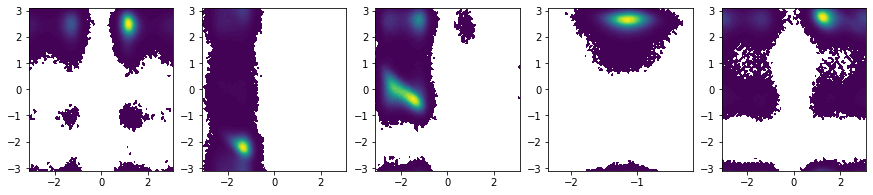

In [144]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    pyemma.plots.plot_density(phi[1][:, i], psi[1][:, i], ax=axs[i], cbar=False)
    plt.tight_layout
#plt.plot(phi[1][:, 2], psi[1][:, 2], 'k.', alpha=0.01)

In [5]:
dihed_traj = np.concatenate((phi[1], psi[1]), axis=1)

### TICA

In [71]:
tica = pyemma.coordinates.tica(dihed_traj, dim=2)

Text(0.5, 0, 'TIC #')

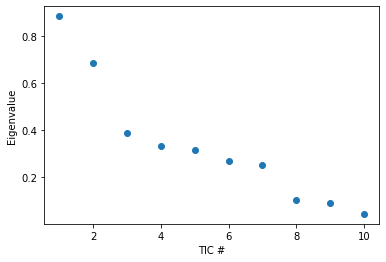

In [145]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 11, 1), tica.eigenvalues, 'o')
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('TIC #')

Text(0, 0.5, 'TIC 2')

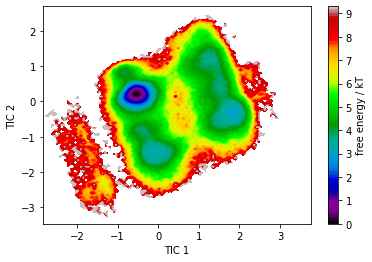

In [147]:
fig, ax = plt.subplots()
pyemma.plots.plot_free_energy(np.concatenate(tica.get_output())[:, 0], np.concatenate(tica.get_output())[:, 1], ax=ax)
ax.set_xlabel('TIC 1')
ax.set_ylabel('TIC 2')

## CNN Clustering

In [74]:
clustering = cluster.Clustering(np.concatenate(tica.get_output())[::100])

In [77]:
clustering.fit(0.1, 20, member_cutoff=10)

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
6011      0.100     20        10        None      5         0.567     0.371     00:00:0.855
-----------------------------------------------------------------------------------------------



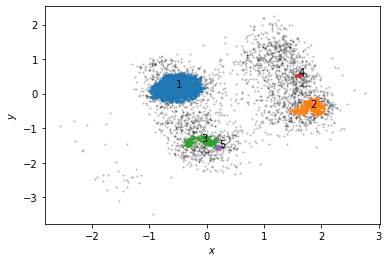

In [78]:
_ = clustering.evaluate()

### Markov State Model

In [79]:
dtrajs = clustering.to_dtrajs()

estimating MaximumLikelihoodMSM:   0%|          | 0/6 [00:00<?, ?it/s]

<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

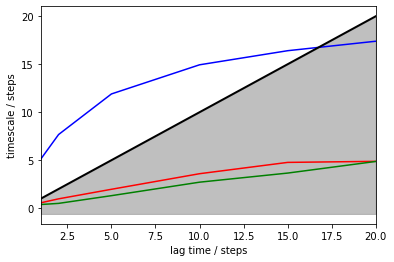

In [82]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 5, 10, 15, 20], nits=3)
pyemma.plots.plot_implied_timescales(its, ylog=False)

In [83]:
MSM = pyemma.msm.estimate_markov_model(dtrajs, lag=15)

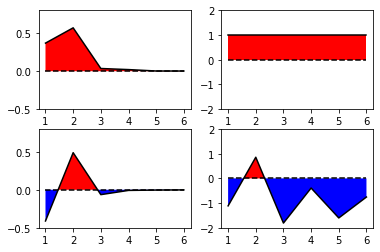

In [164]:
fig, axs = plt.subplots(2, 2)
for i in range(2):
    ax = axs[i][0]
    x = np.arange(1, 7, 1)
    y = MSM.eigenvectors_left()[i]
    ax.plot(x, y, color='k')
    ax.plot(x, [0]*len(x), '--', color='k')
    ax.fill_between(x, 0, y, where= y>=0, facecolor='red', interpolate=True)
    ax.fill_between(x, 0, y, where= y<=0, facecolor='blue', interpolate=True)
    ax.set_ylim(-0.5, 0.8)
    
for i in range(2):
    ax = axs[i][1]
    x = np.arange(1, 7, 1)
    y = MSM.eigenvectors_right()[:, i]
    ax.plot(x, y, color='k')
    ax.plot(x, [0]*len(x), '--', color='k')
    ax.fill_between(x, 0, y, where= y>=0, facecolor='red', interpolate=True)
    ax.fill_between(x, 0, y, where= y<=0, facecolor='blue', interpolate=True)
    ax.set_ylim(-2, 2)

for ax in axs.flat:
    ax.set_xticks(np.arange(1, 7, 1))

In [165]:
ete_data = []
d_100 = md.compute_distances(t[::100], [[0, 75]])
for i in range(6):
    x = d_100[:, 0][np.where(clustering.to_dtrajs()[0] == i, True, False)]
    ete_data.append(x)

Text(0, 0.5, 'End-to-End distance')

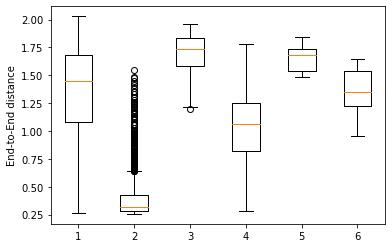

In [167]:
fig, ax = plt.subplots()
ax.boxplot(ete_data)
ax.set_ylabel('End-to-End distance')